# Attribute

**Direct Reference** PINN Repository from Jay Roxis

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Additional Dervative work**: Ben Moseley, PINNs: an introductory crash course

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

# Libraries and Dependencies

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from torch.nn.parameter import Parameter
from torch import (
    linalg,
    nn,
    Tensor,
    stack,
    cat,
    transpose, 
    optim,
    zeros,
    diag,
    reshape
    )
import torch 

from collections import OrderedDict

import scipy.io
import warnings
import time

#For Data Generation
from scipy import signal
from scipy import linalg as linalg2

**Check Device Availability**

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Underlying Model and Training Dataset

In [ ]:
# Mass, stiffness and damping matrices
m1 = 20.0
m2 = 10.0

k1 = 2e3
k2 = 1e3
k3 = 5e3

c1 = 100.0
c2 = 110.0
c3 = 120.0

Mvib = np.asarray([[m1, 0.0], [0.0, m2]], dtype = float)
Cvib = np.asarray([[c1+c2, -c2], [-c2, c2+c3]], dtype = float) 
Kvib = np.asarray([[k1+k2, -k2], [-k2, k2+k3]], dtype = float)

#--------------------------------------------------------------------------
# building matrices in continuous time domain
n = Mvib.shape[0]
I = np.eye(n)
Z = np.zeros([n,n])
Minv = linalg2.pinv(Mvib)

negMinvK = - np.matmul(Minv, Kvib)
negMinvC = - np.matmul(Minv, Cvib)

Ac = np.hstack((np.vstack((Z,negMinvK)), np.vstack((I,negMinvC))))
Bc = np.vstack((Z,Minv))
Cc = np.hstack((I,Z))
Dc = Z.copy()

systemC = (Ac, Bc, Cc, Dc)

#--------------------------------------------------------------------------
# building matrices in discrete time domain
timetotal = 1
t = np.linspace(0,timetotal,1001,dtype = float)
dt = t[1] - t[0]

sD = signal.cont2discrete(systemC, dt)

Ad = sD[0]
Bd = sD[1]
Cd = sD[2]
Dd = sD[3]

systemD = (Ad, Bd, Cd, Dd, dt)

#--------------------------------------------------------------------------
u = np.zeros((t.shape[0], n))
u[:, 0] = 2000*np.ones((t.shape[0],)) # kgmm/s^2
u[:, 1] = 3000*np.ones((t.shape[0],)) # kgmm/s^2

x0 = np.zeros((Ad.shape[1],), dtype = 'float32')

x0[0] = 0.5 # mm
x0[1] = 0.0 # mm

output = signal.dlsim(systemD, u = u, t = t, x0 = x0)
yScipy = output[1]

#Multiplicative noise
yTarget = yScipy + 1e-1 * np.random.randn(yScipy.shape[0], yScipy.shape[1])

#store unpreterbed time
t_store = np.reshape(t, (len(t),1))


### Sparsify Data

In [ ]:
# Voluntary Data cutoff
cutoff = timetotal/4
yTarcut = yTarget[0:250,:]
t_cut = t_store[0:250,:]
u_cut = u[0:250,:]


In [5]:
sparse_count = 125
combined_exact_data = np.hstack((t_cut, u_cut, yTarcut)) #arguments(time,Force,1st and 2nd state) [t_cut u_cut, yTarcut]
idxsparse = np.random.choice(range(int(cutoff/dt)), sparse_count, replace = False)
idxsparse = np.sort(idxsparse)
sparse_exact = combined_exact_data[idxsparse, :]
t_train_sparse = sparse_exact[:,0:1]
F_train_sparse = sparse_exact[:,1:3]
state_train_sparse = sparse_exact[:,3:5]


# PINN Code

### Class for generating dense deep network architecture

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### Physics Informed Neural Network Class

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t_data, t_physics, X, layers, F, M, K, x0):
        
        # Forcing function required to resolve residual
        self.F = torch.tensor(F).float().to(device)
        self.F = torch.reshape(self.F, (len(F),2,1))

        # Store M and K inputs
        self.M = M
        self.K = K
        
        # data
        self.X = torch.tensor(X, requires_grad=True).float().to(device)
        self.t_data = torch.tensor(t_data, requires_grad=True).float().to(device)
        self.t_physics = torch.tensor(t_physics, requires_grad=True).float().to(device)
        
        #optional compartment IC
        self.x1_init = torch.tensor(x0[0], requires_grad=True).float().to(device)
        self.t_init = torch.tensor([[0.]], requires_grad=True).float().to(device)
        self.x2_init = torch.tensor(x0[1], requires_grad=True).float().to(device)
        self.v1_init = torch.tensor(x0[2], requires_grad=True).float().to(device)
        self.v2_init = torch.tensor(x0[3], requires_grad=True).float().to(device)

        # initialize unkown model parameter(s)
        self.c1_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        self.c2_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        self.c3_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        
        # deep neural network
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('c1', self.c1_param)
        self.dnn.register_parameter('c2', self.c2_param)
        self.dnn.register_parameter('c3', self.c3_param)

        # store separate losses for visualization (per epoch)
        self.losses = []
        self.datalosses = []
        self.residlosses = []
        self.ICLosses = []
        # Track model parameter estimates
        self.c1s = []
        self.c2s = []
        self.c3s = []

        # Loss type
        self.MSE = torch.nn.MSELoss()
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 5e-4)
        self.iter = 0

    # Enforce constraints and apply gains to estimated parameters
    @property
    def c1(self):
        return 20*abs(self.c1_param)

    @property
    def c2(self):
        return 20*abs(self.c2_param)

    @property
    def c3(self):
        return 20*abs(self.c3_param)

    def net_x(self, t):  
        x = self.dnn(t)
        x1 = torch.reshape(x[:,0], (len(t),1))
        x2 = torch.reshape(x[:,1], (len(t),1))
        return x1, x2
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """       
        c1 = self.c1
        c2 = self.c2
        c3 = self.c3
        x1net, x2net = self.net_x(t)

        x1net_t = torch.autograd.grad(x1net, t, grad_outputs=torch.ones_like(x1net),create_graph=True)[0]
        x2net_t = torch.autograd.grad(x2net, t, grad_outputs=torch.ones_like(x2net),create_graph=True)[0]

        x1net_tt = torch.autograd.grad(x1net_t, t, grad_outputs=torch.ones_like(x1net_t),create_graph=True)[0]
        x2net_tt = torch.autograd.grad(x2net_t, t, grad_outputs=torch.ones_like(x2net_t),create_graph=True)[0]

        f1 = self.M[0,0]*x1net_tt +(c1+c2)*x1net_t - c2*x2net_t \
            + self.K[0,0]*x1net + self.K[0,1]*x2net - self.F[:,0,0]
        f2 =  self.M[1,1]*x2net_tt +(c1+c3)*x2net_t - c2*x1net_t \
            + self.K[1,1]*x2net + self.K[1,0]*x1net - self.F[:,1,0]
        return f1, f2, x1net_t, x2net_t

    def train(self, nIter, res_scale, data_scale, IC_scale):
        self.dnn.train()
        for epoch in range(nIter+1):
            x1_pred, x2_pred = self.net_x(self.t_data)
            f1, f2, v1net, v2net  = self.net_f(self.t_physics)
            #ICs from network
            x1_pinit, x2_pinit = self.net_x(self.t_init)
            f1init, f2init, v1_pinit, v2_pinit = self.net_f(self.t_init)
            loss_data = (self.MSE(x1_pred[:,0], self.X[:,0])) + self.MSE(x2_pred[:,0], self.X[:,1])
            loss_resid = (torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)))
            loss_IC = self.MSE(x1_pinit[0,0], self.x1_init) + self.MSE(x2_pinit[0,0], self.x2_init) \
                    + self.MSE(v1_pinit[0,0], self.v1_init) + self.MSE(v2_pinit[0,0], self.v2_init)
            loss = data_scale*loss_data + res_scale*loss_resid + IC_scale*loss_IC

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            self.c1s.append(self.c1.item())
            self.c2s.append(self.c2.item())
            self.c3s.append(self.c3.item())

            if epoch % 100 == 0:
                self.losses.append(loss.item())
                self.residlosses.append(res_scale*loss_resid.item())
                self.datalosses.append(data_scale*loss_data.item())
                self.ICLosses.append(IC_scale*loss_IC.item())
                print(
                    'It: %d, Loss: %.3e, c1: %.3f, c2: %.3f, c3: %.3f' % 
                    (
                        epoch, 
                        loss.item(),
                        self.c1.item(),
                        self.c2.item(),
                        self.c3.item()
                    )
                )
    
    def predict(self, t):
        self.dnn.eval()
        #net_x is 'predicted' based off of what is given
        x1, x2= self.net_x(t)
        x1 = x1.detach().cpu().numpy()
        x2 = x2.detach().cpu().numpy()
        return x1, x2

### Execute Training

In [ ]:
#Network Config
layers = [1, 32, 32, 32, 2]
# masses, spring coefficients, and damping coefficients
m = Tensor([[m1, 0.0], [0.0, m2]]).float().to(device)
k = Tensor([[2e3 + 1e3, - 1e3], [- 1e3, 1e3 + 5e3]]).float().to(device)
#Physics mesh
t_phys = np.linspace(0, 1, 1000)
t_phys = np.transpose(t_phys)
t_phys = np.reshape(t_phys, (len(t_phys),1))
# Requires loading case to be known a priori
u_phys = np.zeros((t_phys.shape[0], 2,1))
u_phys[:,0,0] = 2000*np.ones((t_phys.shape[0],)) #defines the input force of a step fn for u1 (in kgmm/s^2)
u_phys[:,1,0] = 3000*np.ones((t_phys.shape[0],))

model = PhysicsInformedNN(t_train_sparse, t_phys, state_train_sparse, layers, u_phys, m, k, x0)

#check number of params
total_params = sum(p.numel() for p in model.dnn.parameters())
print(total_params)

model.train(1000, 0.000001, 10.0, 1.0)# (epochs, residuals, data, IC)

### Visualize Results

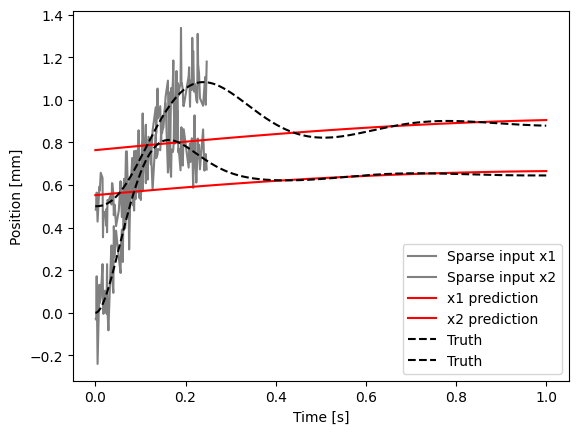

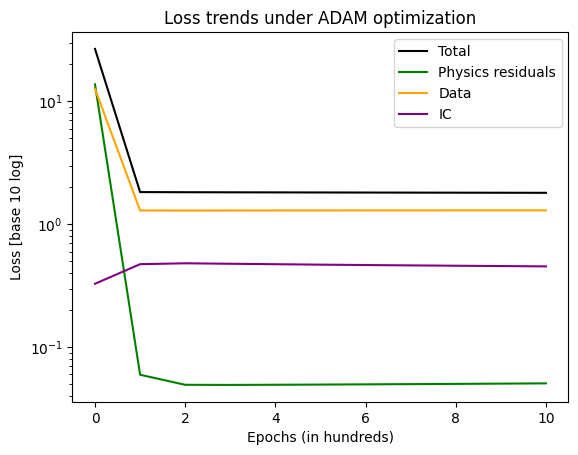

Adam final losses
Loss:  1.8045e+00, Residuals loss: 5.0813e-02, Data loss: 1.2990e+00, IC loss: 4.5475e-01
Estimated c1 value
14.017657279968262
Estimated c2 value
0.00188692647498101
Estimated c3 value
10.763946533203125


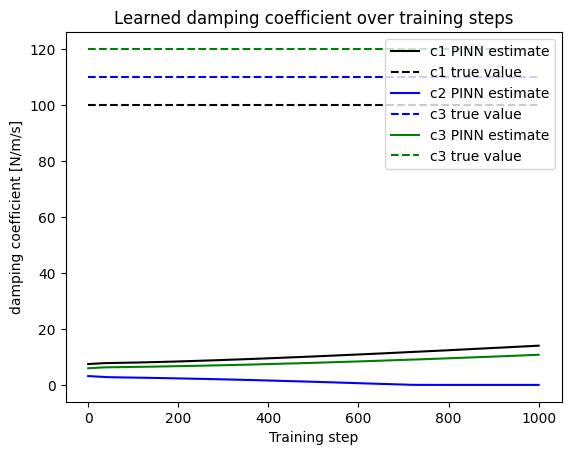

In [ ]:
#plot true result
t_inter = np.linspace(0,1,100)
t_inter = np.transpose(t_inter)
t_inter = np.reshape(t_inter, (len(t_inter),1))
ttensor = torch.tensor(t_inter).float().to(device)
[x1net, x2net] = model.predict(ttensor)
plt.plot(t_train_sparse, state_train_sparse[:,0], color = 'gray', label = 'Sparse input x1')
plt.plot(t_train_sparse, state_train_sparse[:,1], color = 'gray', label = 'Sparse input x2')
plt.plot(t_inter, x1net, color = 'red', label = 'x1 prediction')
plt.plot(t_inter, x2net, color = 'red', label = 'x2 prediction')
plt.plot(t,yScipy, 'k--', label = 'Truth' )
plt.legend()
#plt.title('Network recreation of training dataset')
plt.xlabel('Time [s]')
plt.ylabel('Position [mm]')
plt.show()


#Plot Noisy Loss (ADAM)
plt.plot(model.losses[0:],color = 'black', label = "Total")
plt.plot(model.residlosses[0:],color = 'green', label = "Physics residuals")
plt.plot(model.datalosses[0:],color = 'orange', label = "Data")
plt.plot(model.ICLosses[0:], color = 'purple', label = "IC")
plt.legend()
plt.yscale("log")
plt.title("Loss trends under ADAM optimization")
plt.xlabel('Epochs (in hundreds)')
plt.ylabel('Loss [base 10 log]')
plt.show()

# Print final loss components
print('Adam final losses')
print('Loss:  %.4e, Residuals loss: %.4e, Data loss: %.4e, IC loss: %.4e' %
        (
            model.losses[-1],
            model.residlosses[-1],
            model.datalosses[-1],
            model.ICLosses[-1]
        )
    )

print('Estimated c1 value')
print(model.c1.item())
print('Estimated c2 value')
print(model.c2.item())
print('Estimated c3 value')
print(model.c3.item())

# plot the learned c against the true c
plt.plot(model.c1s, label = 'c1 PINN estimate', color = 'black')
plt.hlines(100, 0, len(model.c1s), label="c1 true value", color="black", linestyle = 'dashed')
plt.plot(model.c2s, label = 'c2 PINN estimate', color = 'blue')
plt.hlines(110, 0, len(model.c2s), label="c3 true value", color="blue", linestyle = 'dashed')
plt.plot(model.c3s, label = 'c3 PINN estimate', color = 'green')
plt.hlines(120, 0, len(model.c1s), label="c3 true value", color="green", linestyle = 'dashed')
plt.legend()
plt.title('Learned damping coefficient over training steps')
plt.xlabel('Epochs')
plt.ylabel('Damping coefficient [Ns/m]')
plt.show()
